# Split up IMPROVE text file into usable, readable csv files for data analysis 
Input: 
 - IMPROVE data text file (download data [here](http://views.cira.colostate.edu/fed/QueryWizard/Default.aspx))<br>

Output: 
 - Site information table exported as csv file 
 - Measurements exported as csv file

In [16]:
"""process_data.ipynb 

Split up IMPROVE text file into usable, readable csv files for data analysis 

Author: Nicole Keeney 
Date Created: 05-28-2021 
Modification History: n/a

"""

import pandas as pd 
import numpy as np 
import scipy.stats
import matplotlib.pyplot as plt
import utils

# Increase notebook resolution of plots
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100

# 1) Read in text file by row 
Each row in the text file will be loaded as a row in a numpy array 

In [17]:
data_dir = "data/"

filename = data_dir + "improve_raw.txt"
with open(filename, "r") as f:
    rows = f.readlines()[1:]
    rows = np.array(rows)

# 2) Extract tabular site information 
Information about the sites included in the measurement table is included near the top of the text file. Here, we split it up by following patterns regarding its likely location in the text file. 

In [18]:
# Get the rows containing site information
sites_start = np.where(rows == 'Sites\n')[0][0] + 2
sites_end = sites_start + np.where(rows[sites_start:] == "\n")[0][0]
sites_txt_tbl = rows[sites_start:sites_end]

# Create pd.DataFrame
sites_df = utils.create_df_from_txt(sites_txt_tbl)
sites_df = sites_df.rename(columns = {"Code":"SiteCode"}) # Rename to match measurement column
display(sites_df.head())

,Site,SiteCode,Dataset,Country,State,County,AQSCode,Latitude,Longitude,Elevation,StartDate,EndDate,DemographicCode,LandUseCode,StreetAddress,LocDesc,Sponsor,ProgramKey,NumPOCs
0,Agua Tibia,AGTI1,IMPAER,US,CA,06065,060659000,33.46360,-116.97060,507,12/20/2000,05/30/2020,-999,Unknown,-999,-999,USFS,IMPROVE,1
1,Bliss SP (TRPA),BLIS1,IMPAER,US,CA,06017,060179000,38.97610,-120.10250,2130,09/01/1990,05/30/2020,-999,Unknown,-999,"Above SW shore of Lake Tahoe, CA,1/4 mile beyo...",USFS,IMPROVE,1
2,Death Valley NP,DEVA1,IMPAER,US,CA,06027,060270101,36.50890,-116.84780,130,09/04/1993,04/28/2013,-999,Unknown,-999,"Furnace Creek, Air quality trailer at Nevares ...",NPS,IMPROVE,1
3,Dome Lands Wilderness,DOLA1,IMPAER,US,CA,06029,060299902,35.69870,-118.20210,914,06/01/1994,12/29/1999,-999,Unknown,-999,"Between Onyx, CA and Walker Pass",-999,IMPROVE,1
4,Dome Lands Wilderness,DOME1,IMPAER,US,CA,06029,060299001,35.72780,-118.13770,927,02/02/2000,05/30/2020,-999,Unknown,-999,-999,USFS,IMPROVE,1


In [15]:
# Save to local drive 
sites_df.to_csv(data_dir + "site_information.csv", index=False)

# 3) Extract tabular measurments  

In [5]:
# Locate and isolate data 
data_start = np.where(rows == 'Data\n')[0][0] + 2
data_txt_tbl = rows[data_start:]

# Reformat as pandas DataFrame
data_df = utils.create_df_from_txt(data_txt_tbl)

# Clean up DataFrame 
data_df = data_df.rename(columns = {'FEf:Val':"Iron", 'SOILf:Val':"Soil"}) # Rename columns to be more easily interpretted 
data_df["Iron"] = data_df["Iron"].astype(float) #Convert numerical values to floats 
data_df["Soil"] = data_df["Soil"].astype(float)

data_df = data_df.replace(-999, np.nan)  # Replace missing val -999 with nan 
data_df = data_df.dropna().reset_index(drop = True) # Drop missing values 
data_df["Date"] = pd.to_datetime(data_df["Date"].values) # Convert date strings to pandas datetime objects 
data_df = data_df.set_index(["Date"]) # Set date as index 

display(data_df.head())

,Dataset,SiteCode,POC,Iron,FEf:StatusFlag,Soil,SOILf:StatusFlag
Date,,,,,,,
2003-01-03,IMPAER,AGTI1,1,0.05512,V0,0.80447,V0
2003-01-06,IMPAER,AGTI1,1,0.43396,V0,7.19411,V0
2003-01-09,IMPAER,AGTI1,1,0.04546,V0,0.72198,V0
2003-01-12,IMPAER,AGTI1,1,0.12538,V0,1.93562,V0
2003-01-15,IMPAER,AGTI1,1,0.06580,V0,0.93589,V0


In [6]:
# Save to local drive 
data_df.to_csv(data_dir + "improve_daily.csv")

# 4) Compute dust using iron proxy method
Derive the linear relationship between iron and soil. Use the slope to estimate fine soil using iron measurements.

In [7]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x = data_df["Iron"].values, y = data_df["Soil"].values)
print("Slope: " + str(round(slope,3)), "\nR value: " + str(round(r_value,3)))

Slope: 13.387 
R value: 0.929


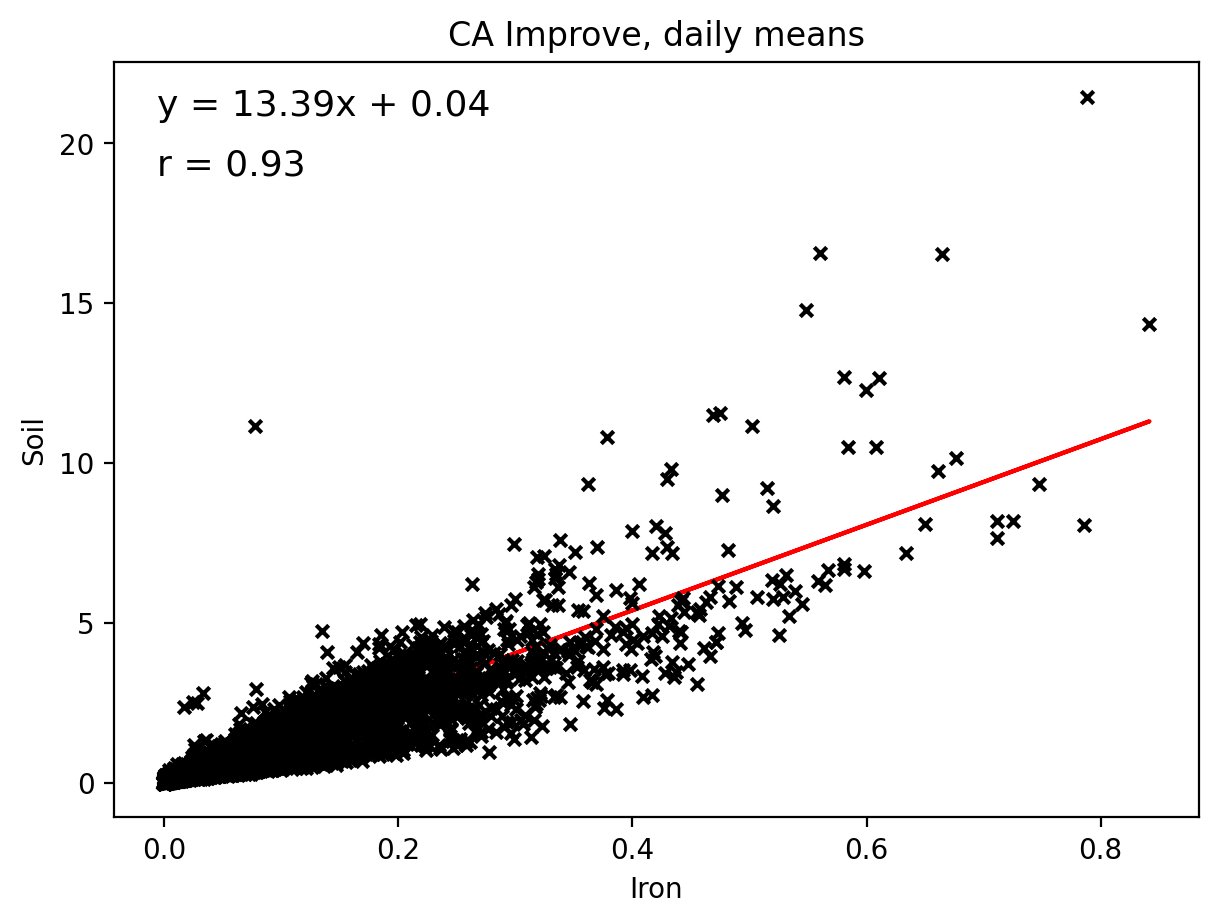

In [8]:
# Make a nice plot! 
utils.plot_iron_proxy(df = data_df, title = "CA Improve, daily means")

In [9]:
# Derive dust approximation 
data_df["Dust"] = slope*data_df["Iron"] 
display(data_df.head())

,Dataset,SiteCode,POC,Iron,FEf:StatusFlag,Soil,SOILf:StatusFlag,Dust
Date,,,,,,,,
2003-01-03,IMPAER,AGTI1,1,0.05512,V0,0.80447,V0,0.737871
2003-01-06,IMPAER,AGTI1,1,0.43396,V0,7.19411,V0,5.809259
2003-01-09,IMPAER,AGTI1,1,0.04546,V0,0.72198,V0,0.608556
2003-01-12,IMPAER,AGTI1,1,0.12538,V0,1.93562,V0,1.678415
2003-01-15,IMPAER,AGTI1,1,0.06580,V0,0.93589,V0,0.880840


# 5) Compute monthly mean dust concentration

In [10]:
# Group by yr, mon and site code
dust = data_df[["SiteCode", "Dust"]]
dust_monthly = dust.groupby([dust.index.year, dust.index.month, "SiteCode"]).agg(['mean', 'count'])
dust_monthly.columns = dust_monthly.columns.droplevel(0)
dust_monthly = dust_monthly.rename_axis(["Year","Month","SiteCode"], axis="index").reset_index()

# Reformat dates 
dates_str = [(str(dust_monthly["Month"].values[i]) + "-" + str(dust_monthly["Year"].values[i])) for i in range(len(dust_monthly))]
datetime_list = pd.to_datetime(dates_str, format = "%m-%Y")
dust_monthly["Date"] = datetime_list 
dust_monthly = dust_monthly.set_index(["Date"]) # Set date as index 
dust_monthly = dust_monthly.drop(columns = ["Month","Year"])
display(dust_monthly.head())

,SiteCode,mean,count
Date,,,
2003-01-01,AGTI1,1.368876,10
2003-01-01,BLIS1,0.082863,10
2003-01-01,DEVA1,0.491650,10
2003-01-01,DOME1,0.163357,10
2003-01-01,HOOV1,0.053935,10


# 6) Screen out months with <50% of daily data available 
Since each month has 10 measurements (1 measurement per every 3 days), >50% of daily data would mean that the month has >= 5 measurements. Here, I'll remove all months that don't have at least 5 measurements. 

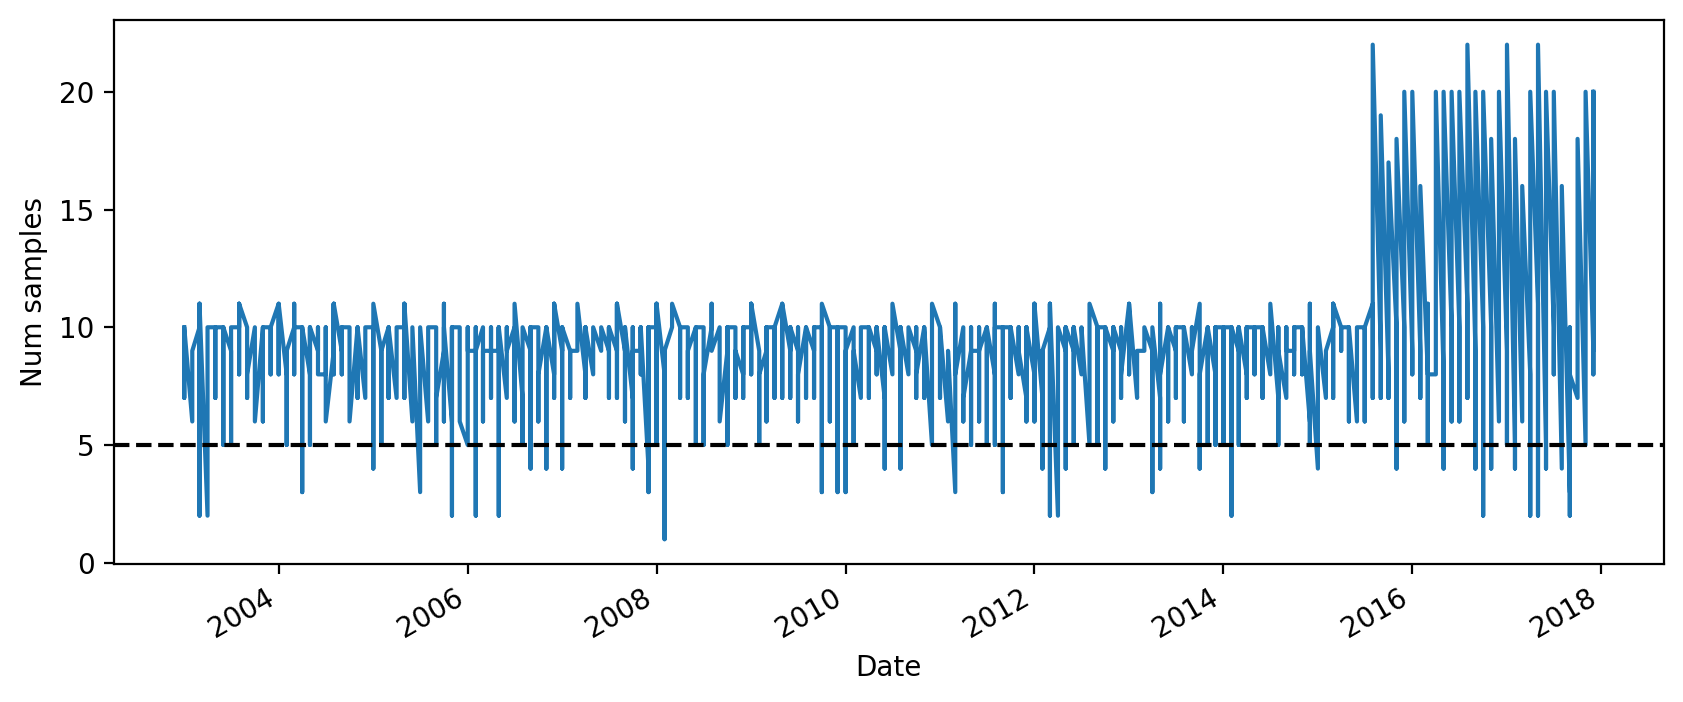

In [11]:
dust_monthly["count"].plot(figsize = (10,4))
plt.axhline(5, color = 'black', linestyle = '--')
plt.ylabel("Num samples");

In [12]:
# This cell can only be run once. You'll need to restart the notebook to run it more than once
# Drop months with < 5 samples
before_len = len(dust_monthly)
dust_monthly = dust_monthly[dust_monthly["count"] >= 5]
after_len = len(dust_monthly)
print("Dropped " + str(before_len - after_len) + " data points")

# Drop count column 
dust_monthly = dust_monthly.drop(columns = "count")
dust_monthly = dust_monthly.rename(columns = {'mean':'Dust'})

Dropped 49 data points


# 7) Merge with site information and save csv

In [13]:
final_df = dust_monthly.copy()
final_df.reset_index(inplace = True)
final_df = pd.merge(final_df, sites_df, on=["SiteCode"])
final_df = final_df[["Date","Dust","Site","SiteCode","State","County","Latitude","Longitude","Elevation","StartDate","EndDate"]]
final_df = final_df.set_index(["Date"]) # Set date as index 
display(final_df.head())

,Dust,Site,SiteCode,State,County,Latitude,Longitude,Elevation,StartDate,EndDate
Date,,,,,,,,,,
2003-01-01,1.368876,Agua Tibia,AGTI1,CA,06065,33.46360,-116.97060,507,12/20/2000,05/30/2020
2003-02-01,0.682048,Agua Tibia,AGTI1,CA,06065,33.46360,-116.97060,507,12/20/2000,05/30/2020
2003-03-01,0.604821,Agua Tibia,AGTI1,CA,06065,33.46360,-116.97060,507,12/20/2000,05/30/2020
2003-05-01,0.680054,Agua Tibia,AGTI1,CA,06065,33.46360,-116.97060,507,12/20/2000,05/30/2020
2003-06-01,0.614674,Agua Tibia,AGTI1,CA,06065,33.46360,-116.97060,507,12/20/2000,05/30/2020


In [14]:
# Save to local drive 
final_df.to_csv(data_dir + "dust.csv")